# About 

This is about the kernel CCA.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import warnings
import time
from tqdm.notebook import tqdm

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import CCA, PLSCanonical
from sklearn.utils import Bunch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import rbf_kernel, euclidean_distances

from cca_zoo.models import CCA as cz_CCA
from cca_zoo.models import rCCA as cz_rCCA
from cca_zoo.model_selection import GridSearchCV as cz_GridSearchCV
from cca_zoo.plotting import pairplot_train_test

rs_num = 42
rng = np.random.default_rng(rs_num)

sklearn.set_config(display="diagram")

n_splits = 5
n_repeats = 20

%matplotlib inline

# 1. Loading Data

In [2]:
# load data
data_path = 'data//'
X_train = np.genfromtxt(data_path+'example_3_2_X_a.csv', delimiter=',')
Y_train = np.genfromtxt(data_path+'example_3_2_X_b.csv', delimiter=',')

# extract dimensions
X_dimension_num = X_train.shape[1]
Y_dimension_num = Y_train.shape[1]

In [3]:
# check if data are standardized
print('For X_train, ')
print('  mean of all:', X_train.mean())
print('  mean of std:', X_train.std(axis=0, ddof=1).mean())

print('For Y_train, ')
print('  mean of all:', Y_train.mean())
print('  mean of std:', Y_train.std(axis=0, ddof=1).mean())

For X_train, 
  mean of all: -6.936250515753359e-17
  mean of std: 0.9999999999999999
For Y_train, 
  mean of all: -1.924386576016938e-17
  mean of std: 1.0


# 2. Example 3.2 - Kernel CCA through manual computation

Note: for `sklearn.metrics.pairwise.rbf_kernel`, the calculation is completed with:

$$
K(x, y) = e^{-gamma ||x-y||^2}
$$

For some notations, the Gaussian kernel would also be expressed as:

$$
K(x, y) = e^{-\frac{||x-y||^2}{2\sigma^2}}
$$

Hence in the following implementation, we may use both notations, where:

$$
gamma = \frac{1}{2\sigma^2}
$$

or 

$$
\sigma = \sqrt{\frac{1}{2~gamma}}
$$

In [4]:
def sigma_to_gamma(sigma):
    return 1.0/(2.0*sigma**2)

def gamma_to_sigma(gamma):
    return np.sqrt(1.0/(2.0*gamma))

In [5]:
def find_sigma_n_gamma(M):
    # matrix M should be in the shape of (sample_num, feature_num)
    # note: the `scipy.spatial.distance.pdist` will provide different results, 
    # compared to the `sklearn.metrics.pairwise.euclidean_distances`
    
#     sigma = np.median(scipy.spatial.distance.pdist(M, metric='euclidean'))
    sigma = np.median(euclidean_distances(M).flatten())
    gamma = sigma_to_gamma(sigma)
    
    return [sigma, gamma]

In [6]:
[sigma_X, gamma_X] = find_sigma_n_gamma(X_train)
[sigma_Y, gamma_Y] = find_sigma_n_gamma(Y_train)

print('For X, the sigma value computed by sklearn is {:.6f}'.format(sigma_X))
print('   where the MATLAB provides: {:.6f}'.format(3.545755088636984))
print('For Y, the sigma value computed by sklearn is {:.6f}'.format(sigma_Y))
print('   where the MATLAB provides: {:.6f}'.format(3.550722209573881))

For X, the sigma value computed by sklearn is 3.545755
   where the MATLAB provides: 3.545755
For Y, the sigma value computed by sklearn is 3.550722
   where the MATLAB provides: 3.550722


In [7]:
def K_centering(K):
    n = K.shape[0]
    D = K.sum(axis=0)/n
    E = D.sum() / n
    J = np.ones((n, 1))*D
    return (K - J - J.T + E*np.ones((n, n)))

In [8]:
def gaussian_cca(X, Y, c1, c2, gamma1, gamma2, n_components, fixed_gamma=True):
    # note: for X and Y, we assume they are standardized already
    sample_num = X.shape[0]
    
    # to see if we need to re-select new gamma values
    if fixed_gamma:
        sigma1 = gamma_to_sigma(gamma1)
        sigma2 = gamma_to_sigma(gamma2)
    else:
        [sigma1, gamma1] = find_sigma_n_gamma(X)
        [sigma2, gamma2] = find_sigma_n_gamma(Y)
    
    # compute for K matrices
    Kx = rbf_kernel(X, X, gamma1)
    Ky = rbf_kernel(Y, Y, gamma2)
    
    # center K matrices
    Kx_centered = K_centering(Kx)
    Ky_centered = K_centering(Ky)
    
    A = np.zeros((2*sample_num, 2*sample_num))
    A[:sample_num, sample_num:] = Kx_centered.dot(Ky_centered)
    A[sample_num:, :sample_num] = Ky_centered.dot(Kx_centered)
    
    B = np.zeros_like(A)
    B[:sample_num, :sample_num] = np.linalg.matrix_power(
        Kx_centered + c1 * np.eye(sample_num), 2
    )
    B[sample_num:, sample_num:] = np.linalg.matrix_power(
        Ky_centered + c2 * np.eye(sample_num), 2
    )
    
    # solve for generalized eigenvalue problem
    [eig_val, eig_vec] = scipy.linalg.eigh(A, B)
    
    eig_val_positive = eig_val[eig_val>=0.0]
    eig_vec_positive = eig_vec[:, eig_val>=0.0]
    
    sort_ind = eig_val_positive.argsort() # ascending order; use [::-1] for descending order
    eig_val_positive_sorted = eig_val_positive[sort_ind[::-1]]
    eig_vec_positive_sorted = eig_vec_positive[:, sort_ind[::-1]]
    
    # slicing components
    eig_val_positive_sorted = eig_val_positive_sorted[:n_components]
    alpha_sorted = eig_vec_positive_sorted[:sample_num, :n_components]
    beta_sorted = eig_vec_positive_sorted[sample_num:, :n_components]
    
    return [eig_val_positive_sorted, alpha_sorted, beta_sorted, gamma1, gamma2, sigma1, sigma2]

In [9]:
def custom_cv(validator, X, Y, fit_n_score_func, *args):
    # note: normally X and Y are already training datasets
    
    # construct score array
    score_arr = np.zeros((validator.get_n_splits(), ))
    
    # fit and validate
    ii = 0
    
    for train_ind, test_ind in validator.split(X):
        # slicing arrays
        X_train, X_test = X[train_ind], X[test_ind]
        Y_train, Y_test = Y[train_ind], Y[test_ind]
        
        # train the model and get the score
        score_arr[ii] = fit_n_score_func(X_train, X_test, Y_train, Y_test, *args)
        ii += 1
    
    return score_arr

In [10]:
def manual_gaussian_kcca_fit_n_score(
    X_train, X_test, Y_train, Y_test, c1, c2, gamma1, gamma2, 
    n_components, fixed_gamma=True
):
    # standardize matrices 
    # note: in most cases, the test datasets should be standardized 
    # with the training dataset means and stds
    X_train_standardized = StandardScaler().fit_transform(X_train)
    Y_train_standardized = StandardScaler().fit_transform(Y_train)
    X_test_standardized = StandardScaler().fit_transform(X_test)
    Y_test_standardized = StandardScaler().fit_transform(Y_test)
    
    # fit the model
    [_, alpha, beta, gamma1, gamma2, sigma1, sigma2] = gaussian_cca(
        X_train_standardized, Y_train_standardized, 
        c1, c2, gamma1, gamma2, n_components, fixed_gamma
    )
    
    # map the test datasets
#     Kx_test = rbf_kernel(X_test_standardized, X_train_standardized, gamma1)
#     Ky_test = rbf_kernel(Y_test_standardized, Y_train_standardized, gamma2)
    
    # Note: these use `sigma`, not `gamma`
    Kx_test = rbf_kernel(X_test_standardized, X_train_standardized, sigma1)
    Ky_test = rbf_kernel(Y_test_standardized, Y_train_standardized, sigma2)
    
    # score on the test datasets
    # note: over here, we only take the first component
    Xc_test = Kx_test.dot(alpha[:, 0])
    Yc_test = Ky_test.dot(beta[:, 0])
    score = cosine_similarity(
        Xc_test.reshape(1, -1), 
        Yc_test.reshape(1, -1)
    )[0][0]
    
    return score

## 2.1. Find the Optimal $c_1$ and $c_2$

In [11]:
# parameter grid
c1_arr = np.arange(0.2, 1.5+0.1, 0.1)
c2_arr = np.arange(0.2, 1.5+0.1, 0.1)

In [12]:
gamma1_ref = gamma_X
gamma2_ref = gamma_Y
n_components = 10
fixed_gamma = False

# try to find only c1 and c2
score_arr = np.zeros((c1_arr.size, c2_arr.size))
rkf = RepeatedKFold(
    n_splits=n_splits, 
    n_repeats=n_repeats, 
    random_state=rs_num
)

score_arr_all = np.zeros((c1_arr.size, c2_arr.size, n_repeats*n_splits))

for c1_i, c1 in enumerate(tqdm(c1_arr)):
    for c2_i, c2 in enumerate(c2_arr):
        scores_this_iter = custom_cv(
            rkf, 
            X_train, Y_train, 
            manual_gaussian_kcca_fit_n_score, 
            c1, c2, gamma1_ref, gamma2_ref, 
            n_components, fixed_gamma
        )
        score_arr_all[c1_i, c2_i, :] = scores_this_iter.copy()

score_arr = np.nanmean(score_arr_all, 2)

  0%|          | 0/14 [00:00<?, ?it/s]

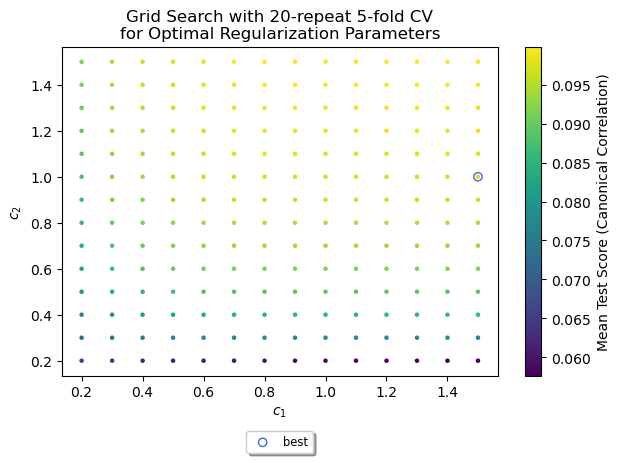

In [13]:
c1_arr_viz, c2_arr_viz = np.meshgrid(c1_arr, c2_arr)
argmax_ind = np.unravel_index(score_arr.argmax(), np.array(score_arr).shape)
c1_opt = c1_arr[argmax_ind[0]]
c2_opt = c2_arr[argmax_ind[1]]

fig, ax = plt.subplots()

sc = ax.scatter(
    c1_arr_viz, c2_arr_viz, c=score_arr, s=5
)
cbar = plt.colorbar(sc)
cbar.set_label('Mean Test Score (Canonical Correlation)')
ax.scatter(
    c1_opt, 
    c2_opt, 
    marker='o',
    ec='royalblue', 
    fc='none', 
    label='best'
)

ax.set(
    xlabel='$c_1$', 
    ylabel='$c_2$', 
    title=(
        'Grid Search with {}-repeat {}-fold CV'.format(n_repeats, n_splits) + 
        '\nfor Optimal Regularization Parameters'
    )
)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True,
    ncol=1,
    fontsize='small'
)


fig.tight_layout()

In [14]:
print('The c1 optimal is {:.2f} and the c2 optimal is {:.2f}'.format(c1_opt, c2_opt))

The c1 optimal is 1.50 and the c2 optimal is 1.00


However, if we take a look at the example code, the optimal values found by that script are actually `c1=1.5` and `c2=0.8`.
If we examine the same average values for all candidates:

<img src="figs/chap_3_kcca_c1c2_candidates.jpg" alt="c1c2candidates" width="500"/>

They have the same trending, but the maximum and minimum are not quite the same.
This can be caused by the randomness from the training and test spliting during the cross-validation progress.

Also to test out if different canonical correlation computing methods would make a difference, we can try the following scripts.

In [15]:
def test_cc_computing_methods(X, Y):
    # some constants
    n_train = 120
    gamma1 = 0.0397697
    gamma2 = 0.0396585
    n_components = 10
    c1 = 1.50
    c2 = 1.00
    fixed_gamma = True
    
    
    X_train = X[:n_train, :]
    Y_train = Y[:n_train, :]
    X_test = X[n_train:, :]
    Y_test = Y[n_train:, :]
    
    X_train_standardized = StandardScaler().fit_transform(X_train)
    Y_train_standardized = StandardScaler().fit_transform(Y_train)
    X_test_standardized = StandardScaler().fit_transform(X_test)
    Y_test_standardized = StandardScaler().fit_transform(Y_test)
    
    [_, alpha, beta, gamma1, gamma2, sigma1, sigma2] = gaussian_cca(
        X_train_standardized, Y_train_standardized, 
        c1, c2, gamma1, gamma2, n_components, fixed_gamma
    )
    
    Kx_test = rbf_kernel(X_test_standardized, X_train_standardized, sigma1)
    Ky_test = rbf_kernel(Y_test_standardized, Y_train_standardized, sigma2)
    
    Xc_test = Kx_test.dot(alpha[:, 0])
    Yc_test = Ky_test.dot(beta[:, 0])
    
    Xc_test_normalized = normalize(Xc_test.reshape(1, -1)).flatten()
    Yc_test_normalized = normalize(Yc_test.reshape(1, -1)).flatten()
    
    print('For cosine similarities before normalization:')
    score = cosine_similarity(
        Xc_test.reshape(1, -1), 
        Yc_test.reshape(1, -1)
    )[0][0]
    print(score)
    print()
    
    print('For cosine similarities after normalization:')
    score = cosine_similarity(
        Xc_test_normalized.reshape(1, -1), 
        Yc_test_normalized.reshape(1, -1)
    )[0][0]
    print(score)
    print()
    
    print('For dot product of images:')
    score = Xc_test_normalized.dot(Yc_test_normalized)
    print(score)

In [16]:
test_cc_computing_methods(X_train, Y_train)

For cosine similarities before normalization:
0.23880355601923878

For cosine similarities after normalization:
0.2388035560192388

For dot product of images:
0.23880355601923878


It looks the difference is minimum.

## 2.2. Solve CCA with Optimal Parameters

In [17]:
def compute_cc_arr(
    X_train, Y_train, c1, c2, 
    gamma_X, gamma_Y, n_components, fixed_gamma
):
    [_, alpha, beta, _, _, _, _] = gaussian_cca(
        X_train, Y_train, c1, c2, 
        gamma_X, gamma_Y, n_components, fixed_gamma
    )
    
    # compute for K matrices
    Kx = rbf_kernel(X_train, X_train, gamma_X)
    Ky = rbf_kernel(Y_train, Y_train, gamma_Y)

    # center K matrices
    Kx_centered = K_centering(Kx)
    Ky_centered = K_centering(Ky)
    
    # calculate canonical correlation
    Xc = Kx_centered.dot(alpha)
    Yc = Ky_centered.dot(beta)
    cc_arr = np.diag(cosine_similarity(
        Xc.T, Yc.T
    ))
    
    return [cc_arr, alpha, beta, Xc, Yc]

In [18]:
fixed_gamma = True
n_components = 3
c1_preset = 1.5 # use preset value
c2_preset = 0.8 # use preset value

[cc_arr, alpha, beta, Xc, Yc] = compute_cc_arr(
    X_train, Y_train, c1_preset, c2_preset, 
    gamma_X, gamma_Y, n_components, fixed_gamma
)

In [19]:
print('The cc array computed with this notebook is:')
print(np.array_str(cc_arr, precision=5))
print('  where the cc array computed by the example MATLAB codes:')
print(np.array_str(
    np.array([0.9515039399, 0.8857752621, 0.8215406102]), 
    precision=5
))

The cc array computed with this notebook is:
[0.9515  0.88578 0.82154]
  where the cc array computed by the example MATLAB codes:
[0.9515  0.88578 0.82154]


It looks good!
Also we can check out if the transformed data can reflect the latent correlation in the data, i.e.,

- $y_1 = e^{x_3}$
- $y_2 = x_1^3$
- $y_3 = -x_4$

In [20]:
corr_cmap = sns.color_palette('vlag', as_cmap=True)

print('For the 1st pair:')
data_df_corr = pd.DataFrame(
    data={
        'zx_1': Xc[:, 0], 
        'zy_1': Yc[:, 0], 
        'exp(x_3)': np.exp(X_train[:, 2]), 
        'x_1^3': np.power(X_train[:, 0], 3), 
        '-x_4': -X_train[:, 3], 
        'y_1': Y_train[:, 0], 
        'y_2': Y_train[:, 1], 
        'y_3': Y_train[:, 2]
    }
).corr()

display(
    data_df_corr.iloc[:2, 2:].style.background_gradient(cmap=corr_cmap).format(precision=2)
)

print('This pair reveals the correlation y_3=-x_4')

For the 1st pair:


,exp(x_3),x_1^3,-x_4,y_1,y_2,y_3
zx_1,-0.01,-0.10,-0.98,-0.01,-0.10,-0.95
zy_1,0.01,-0.11,-0.94,0.00,-0.11,-0.99


This pair reveals the correlation y_3=-x_4


In [21]:
print('For the 2nd pair:')
data_df_corr = pd.DataFrame(
    data={
        'zx_2': Xc[:, 1], 
        'zy_2': Yc[:, 1], 
        'exp(x_3)': np.exp(X_train[:, 2]), 
        'x_1^3': np.power(X_train[:, 0], 3), 
        '-x_4': -X_train[:, 3], 
        'y_1': Y_train[:, 0], 
        'y_2': Y_train[:, 1], 
        'y_3': Y_train[:, 2]
    }
).corr()

display(
    data_df_corr.iloc[:2, 2:].style.background_gradient(cmap=corr_cmap).format(precision=2)
)

print('This pair reveals the correlation y_2=x_1^3')

For the 2nd pair:


,exp(x_3),x_1^3,-x_4,y_1,y_2,y_3
zx_2,0.16,-0.78,0.11,0.14,-0.79,0.04
zy_2,0.12,-0.92,0.09,0.12,-0.94,0.03


This pair reveals the correlation y_2=x_1^3


In [22]:
print('For the 3rd pair:')
data_df_corr = pd.DataFrame(
    data={
        'zx_3': Xc[:, 2], 
        'zy_3': Yc[:, 2], 
        'exp(x_3)': np.exp(X_train[:, 2]), 
        'x_1^3': np.power(X_train[:, 0], 3), 
        '-x_4': -X_train[:, 3], 
        'y_1': Y_train[:, 0], 
        'y_2': Y_train[:, 1], 
        'y_3': Y_train[:, 2]
    }
).corr()

display(
    data_df_corr.iloc[:2, 2:].style.background_gradient(cmap=corr_cmap).format(precision=2)
)

print('This pair reveals the correlation y_1=exp(x_3)')

For the 3rd pair:


,exp(x_3),x_1^3,-x_4,y_1,y_2,y_3
zx_3,-0.67,-0.12,-0.07,-0.64,-0.10,-0.04
zy_3,-0.75,-0.21,-0.06,-0.75,-0.19,-0.03


This pair reveals the correlation y_1=exp(x_3)


## 2.3. Solve CCA with Minor Improvements

For this sub-section, we can make some minor improvements to the scripts to see if we can obtain better correlation.